## В этом проекте используется сравнение архитектур на базе свёрточных слоёв с использованием Conv2DTranspose и без Conv2DTranspose / This project uses a convolutional layer architecture using Conv2DTranspose and without Conv2DTranspose.

## Импорт библиотек / Importing Libraries

In [ ]:
import numpy as np # linear algebra/ линейная алгебра
import pandas as pd # data processing/ обработка данных CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import cv2 as cv
import matplotlib.pyplot as plt

## Скачивание данных c kaggle.com / Downloading data from kaggle.com

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"annaguskova","key":"40aae2602cabb9aaa3df4569493bb55a"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle datasets download -d crawford/cat-dataset

cat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/cat-dataset.zip -d kaggle 

In [ ]:

!rm -f /content/PetImages/Cat/15*
!rm -f /content/PetImages/Cat/13*
!rm -f /content/PetImages/Cat/12*
!rm -f /content/PetImages/Cat/16*
!ls /content/kaggle/CAT_00

In [ ]:
os.listdir('/content/kaggle/CAT_00')

In [ ]:
os.listdir('/content/kaggle/cats')

['CAT_04', 'CAT_05', 'CAT_03', 'CAT_01', 'CAT_06', 'CAT_00', 'CAT_02']

## Подготовка изображений / Preparing images

In [ ]:
def img_preprocess():
    img_list = []

    for img_path in glob('/content/kaggle/CAT_00/*.jpg'):
        img = cv.imread(img_path)            #cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB / cv 3-dim，last_channel = 3，RGB
        img = cv.resize(img, (224, 224))     #преобразование формы в (224, 224) / shape (224, 224)
        sc_img = img.astype('float') / 255   #нормализация / normalization
        img_list.append(sc_img)
    
    return np.asarray(img_list)

In [ ]:
img_arr = img_preprocess()

([], <a list of 0 Text major ticklabel objects>)

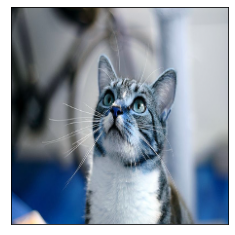

In [ ]:
plt.imshow(img_arr[168])
plt.xticks([])
plt.yticks([])

In [ ]:
img_arr.shape

(1706, 224, 224, 3)

##Построение модели / Build Model
##Свёрточный AutoEncoder  / Convolutional AutoEncoder 

In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(filters=64,
           kernel_size=(3,3),
           padding='same', 
           activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2),
                             strides=(2,2))(x)

x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(encoder_layer)
x = UpSampling2D(size=(2,2))(x)  # Функция UpSampling2D заключается в усилении (восстановлении) вектора после традиционной свертки Down Sample.Это также можно назвать «деконволюцией» / 
# The UpSampling2D function is to amplify (restore) the vector after the traditional Down Sample convolution. This can also be called "deconvolution".
x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=64,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
decoder_layer = Conv2D(filters=3,
                       kernel_size=(3,3),
                       padding='same',
                       activation='sigmoid')(x)

# Создание свёрточного AutoEncoder / Convolutional AutoEncoder 
conv_auto_encoder = Model(input_layer, decoder_layer)

#Создание Encoder 
encoder = Model(input_layer, encoder_layer)


In [ ]:
conv_auto_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0     

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=100, batch_size=64,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

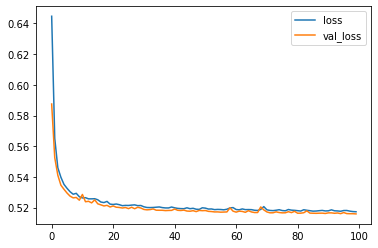

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

In [ ]:
print ('Low dimention shape: {}'.format(encoded[0].shape))
print ('output dimention shape: {}'.format(decoded[0].shape))

Low dimention shape: (28, 28, 32)
output dimention shape: (224, 224, 3)


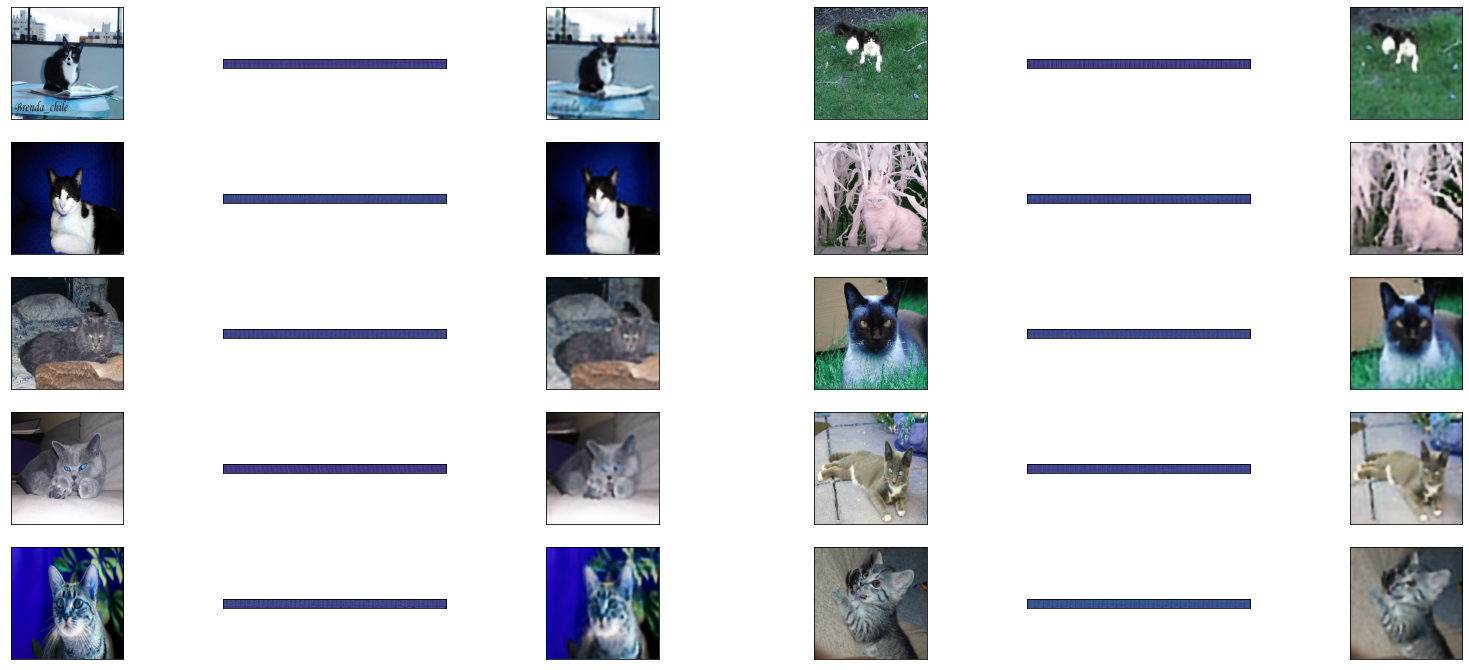

In [ ]:
fig = plt.figure(figsize=(28, 12))
n_plot = 10
n_rows = int(n_plot / 2)
next = 30

for j in range(n_plot):
    #Исходное входное значение（Input)
    fig.add_subplot(n_rows, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j+next])
    plt.xticks([])
    plt.yticks([])
    #Низкоразмерный массив / low-dimensional array
    fig.add_subplot(n_rows, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j+next].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    #Восстановленные исходные данные (Deconded)
    fig.add_subplot(n_rows, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j+next])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Conv2DTranspose 

In [ ]:
input_layer = Input(shape=(img_arr.shape[1], img_arr.shape[2], img_arr.shape[3]))

x = Conv2D(filters=64,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(encoder_layer)
x = Conv2DTranspose(filters=32,
                    kernel_size=(3,3),
                    strides=(2,2),
                    padding='same',
                    use_bias=True,
                    activation='relu')(x)
x = Conv2D(filters=32,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = Conv2DTranspose(filters=32,
                    kernel_size=(3,3),
                    strides=(2,2),
                    padding='same',
                    use_bias=True,
                    activation='relu')(x)
x = Conv2D(filters=64,
           kernel_size=(3,3),
           padding='same',
           activation='relu')(x)
x = Conv2DTranspose(filters=64,
                    kernel_size=(3,3),
                    strides=(2,2),
                    padding='same',
                    use_bias=True,
                    activation='relu')(x)
decoder_layer = Conv2D(filters=3,
                       kernel_size=(3,3),
                       padding='same',
                       activation='sigmoid')(x)

#Создание Convolutional AutoEncoder / Convolutional AutoEncoder 
conv_auto_encoder = Model(input_layer, decoder_layer)

#Настройка Encoder
encoder = Model(input_layer, encoder_layer)

In [ ]:
conv_auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0   

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=100, batch_size=64,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

In [ ]:
print ('encoded img shape {}'.format(encoded.shape))
print ('decoded img shape {}'.format(decoded.shape))

encoded img shape (1706, 28, 28, 32)
decoded img shape (1706, 224, 224, 3)


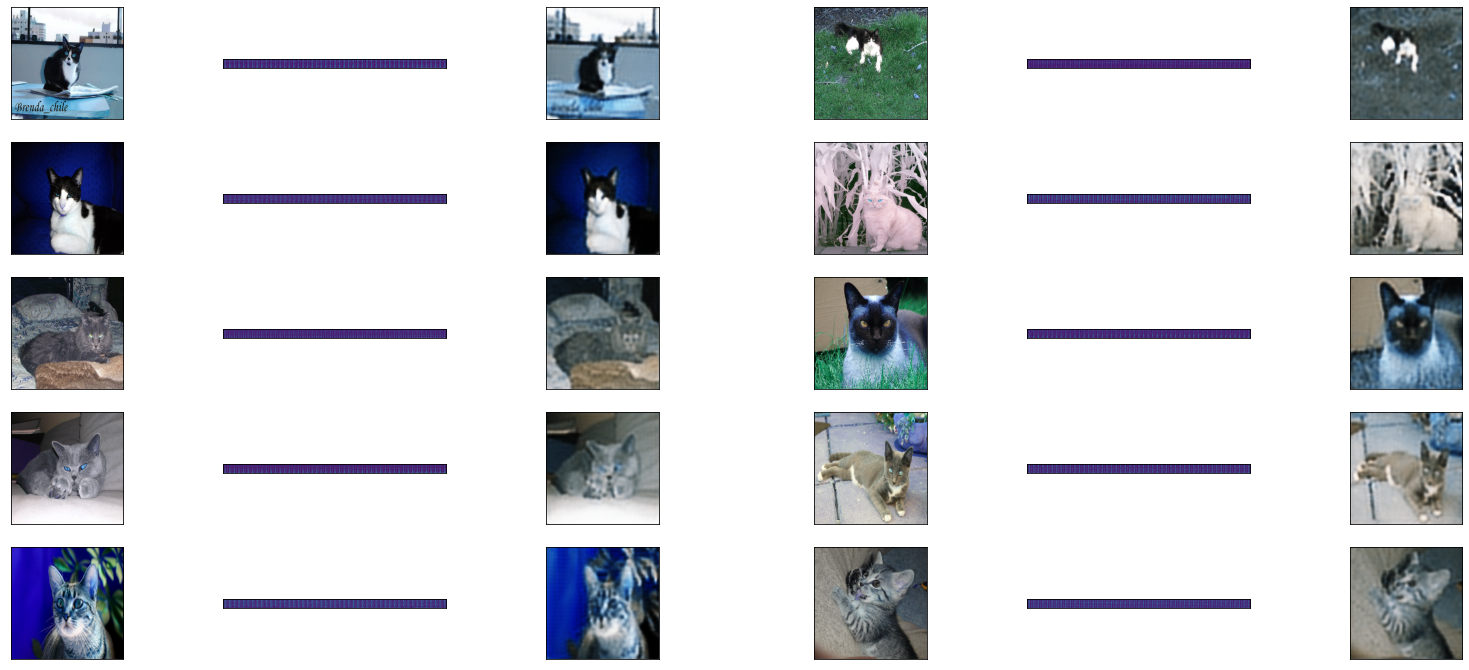

In [ ]:
fig = plt.figure(figsize=(28, 12))
n_plot = 10
n_rows = int(n_plot / 2)
next = 30

for j in range(n_plot):
  #（Input）
    fig.add_subplot(n_rows, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j+next])
    plt.xticks([])
    plt.yticks([])
    
    fig.add_subplot(n_rows, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j+next].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    #-- Decoder 
    fig.add_subplot(n_rows, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j+next])
    plt.xticks([])
    plt.yticks([])
plt.show()